# Analyze Time Table

Analyze the time table of COUNT DOWN JAPAN/ROCK'IN ON JAPAN

Hypothesis.


* Attendance Probability: will dependes on past attendances.
  * As count of attendance increase, attendance probability will increase.
* Time Table Probability: will depends on past or recent time table.
  * Attending time (day) will be different from past / recent fes time table.


## Preparation

In [38]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
%matplotlib inline

In [40]:
def set_path():
    root = os.path.join(os.path.realpath("."), "../")
    if root not in sys.path:
        sys.path.append(root)
    return root

DATA_DIR = os.path.join(set_path(), "data/raw")
if not os.path.exists(DATA_DIR):
    raise Exception("Data dir does not exist. Please Run 'Get Fes dataset'first.")

## Analyze Time Table

In [41]:
df_cdj = pd.read_csv(os.path.join(DATA_DIR, "cdj.csv"))
df_cdj.head(3)

,artist,day,day_index,detail_link,stage,year
0,B-DASH,12/29,1,/wiki/B-DASH,EARTH STAGE,2003
1,ASIAN KUNG-FU GENERATION,12/29,1,/wiki/ASIAN_KUNG-FU_GENERATION,EARTH STAGE,2003
2,斉藤和義,12/29,1,/wiki/%E6%96%89%E8%97%A4%E5%92%8C%E7%BE%A9,EARTH STAGE,2003


In [42]:
df_rinj = pd.read_csv(os.path.join(DATA_DIR, "rinj.csv"))
df_rinj.head(3)

,artist,day,day_index,detail_link,stage,year
0,AIR,8/12,1,/wiki/%E8%BB%8A%E8%B0%B7%E6%B5%A9%E5%8F%B8,STAGE,2000
1,エレファントカシマシ,8/12,1,/wiki/%E3%82%A8%E3%83%AC%E3%83%95%E3%82%A1%E3%...,STAGE,2000
2,くるり,8/12,1,/wiki/%E3%81%8F%E3%82%8B%E3%82%8A,STAGE,2000


### Attendance Probability

In [43]:
def cross_by_year(df, discount_rate=0.9):
    ct = pd.crosstab(df["artist"], df["year"], rownames=["artist"], colnames=["year"])
    
    def discount(x):
        _exp = np.arange(len(x))[::-1]
        rates = np.array([discount_rate] * len(x))
        v = np.power(rates, _exp)
        return x * v
    
    ct = pd.DataFrame(ct)
    d_ct = ct.apply(discount, axis=1)
    return ct, d_ct

In [44]:
ct, ct_d = cross_by_year(df_cdj)

In [45]:
ct_d.head(5)

year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
artist,,,,,,,,,,,,,,,,
0.8秒と衝撃。,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.6561,0.000,0.00,0.0,0.0
04 Limited Sazabys,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.6561,0.729,0.81,0.9,1.0
10-FEET,0.205891,0.228768,0.254187,0.28243,0.313811,0.348678,0.0,0.430467,0.478297,0.531441,0.59049,0.6561,0.729,0.81,0.9,1.0
100s,0.000000,0.228768,0.000000,0.28243,0.000000,0.348678,0.0,0.000000,0.000000,0.000000,0.00000,0.0000,0.000,0.00,0.0,0.0
175R,0.000000,0.228768,0.000000,0.00000,0.000000,0.000000,0.0,0.430467,0.000000,0.000000,0.00000,0.0000,0.000,0.00,0.9,0.0


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


def try_prediction(target, feature=None, test_size=0.33):
    X = feature
    if feature is None:
        X = target
    
    result = {}
    for i, c in enumerate(X.columns[1:], start=1):
        p = X.columns[i - 1]
        _X = X[p].values.reshape(-1, 1)
        y = target[c]
        X_train, X_test, y_train, y_test = train_test_split(_X, y, test_size=test_size)
        model = LogisticRegression(solver="liblinear", multi_class="ovr").fit(X_train, y_train)
        score = model.score(X_test, y_test)
        result["{}=>{}".format(p, c)] = score

    result = pd.Series(result)
    result.plot.bar()
    return result

0.8478696741854638


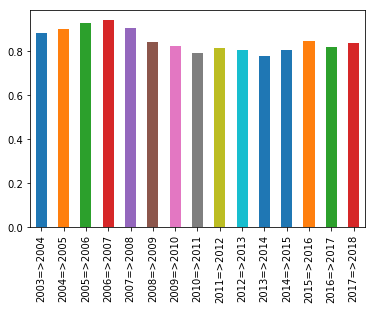

In [47]:
predict_from_previous = try_prediction(ct)
print(predict_from_previous.mean())

0.8408521303258145


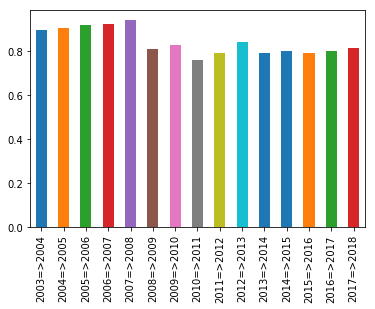

In [48]:
predict_from_cumsum = try_prediction(ct, ct_d.cumsum(axis=1))
print(predict_from_cumsum.mean())

0.869765908341576


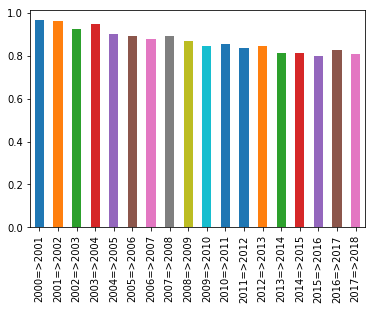

In [49]:
ct_rinj, ct_d_rinj = cross_by_year(df_rinj)
predict_from_previous_rinj = try_prediction(ct_rinj)
print(predict_from_previous_rinj.mean())

0.8692713484998351


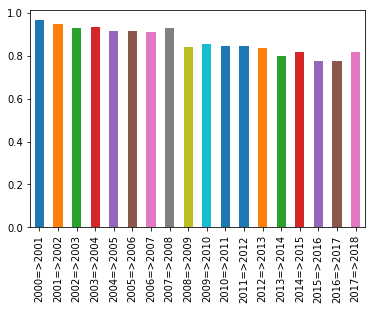

In [50]:
predict_from_cumsum_rinj = try_prediction(ct_rinj, ct_d_rinj.cumsum(axis=1))
print(predict_from_cumsum_rinj.mean())

## Time Table Probability

In [51]:
def make_day_feature(df):
    categorical_day = pd.get_dummies(df["day_index"], prefix="day_category")
    feature_added = pd.concat([df, categorical_day], axis=1)
    return feature_added

In [52]:
f_cdj = make_day_feature(df_cdj)
f_cdj.head(3)

,artist,day,day_index,detail_link,stage,year,day_category_1,day_category_2,day_category_3,day_category_4
0,B-DASH,12/29,1,/wiki/B-DASH,EARTH STAGE,2003,1,0,0,0
1,ASIAN KUNG-FU GENERATION,12/29,1,/wiki/ASIAN_KUNG-FU_GENERATION,EARTH STAGE,2003,1,0,0,0
2,斉藤和義,12/29,1,/wiki/%E6%96%89%E8%97%A4%E5%92%8C%E7%BE%A9,EARTH STAGE,2003,1,0,0,0


In [53]:
f_rinj = make_day_feature(df_rinj)

In [54]:
def predict_day(df, from_year, target_year, cumsum=False, test_size=0.33, feature=None):
    f_columns =  [c for c in df.columns if c.startswith("day_category")]
    feature = feature
    if feature is None:
        feature = df

    if not cumsum:
        X = feature[feature["year"] == from_year][["artist"] + f_columns]
    else:
        X = feature[feature["year"] <= from_year][["artist"] + f_columns].groupby(["artist"])[f_columns].sum().reset_index()
    
    y = df[df["year"] == target_year][["artist", "day_index"]]
 
    Xy = y.merge(X, left_on="artist", right_on="artist", how="left").fillna(0)
    X = Xy[f_columns]
    y = Xy["day_index"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    model = LogisticRegression(solver="liblinear", multi_class="ovr", class_weight="balanced").fit(X_train, y_train)
    score = model.score(X_test, y_test)
    return score

In [67]:
def predict_day_all(df, cumsum=False, feature=None):
    years = df["year"].value_counts().index.values.astype(int)
    years.sort()
    result = {}
    for i, y in enumerate(years[1:], start=1):
        previous = years[i - 1]
        target = y
        score = predict_day(df, previous, target, cumsum=cumsum, feature=feature)
        result["{} => {}".format(previous, target)] = score
    
    result = pd.Series(result)
    result.plot.bar()
    return result

#### COUNT DOWN JAPAN

0.3439522476961237


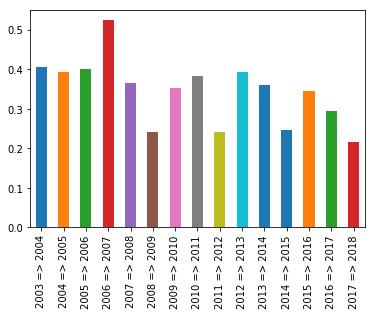

In [70]:
predict_from_previous_day = predict_day_all(f_cdj)
print(predict_from_previous_day.mean())

0.2827117049400243


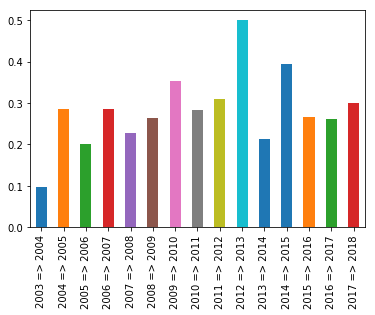

In [71]:
predict_from_previous_day_cum = predict_day_all(f_cdj, cumsum=True)
print(predict_from_previous_day_cum.mean())

#### ROCK IN JAPAN

0.2912940480887443


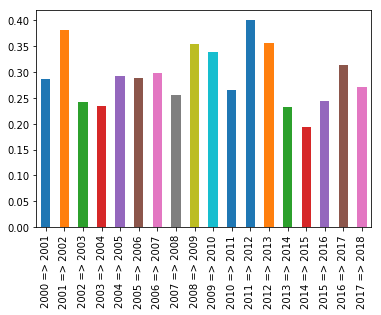

In [72]:
predict_from_previous_day_rinj = predict_day_all(f_rinj)
print(predict_from_previous_day_rinj.mean())

0.27131777996693496


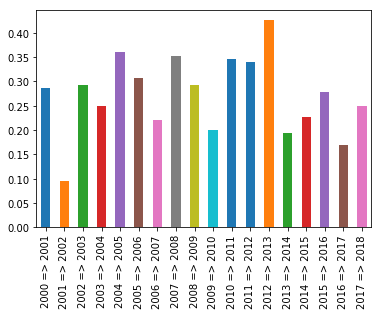

In [73]:
predict_from_previous_day_rinj = predict_day_all(f_rinj, cumsum=True)
print(predict_from_previous_day_rinj.mean())

### COUNT DOWN JAPAN from ROCK IN JAPAN

0.28566904509032826


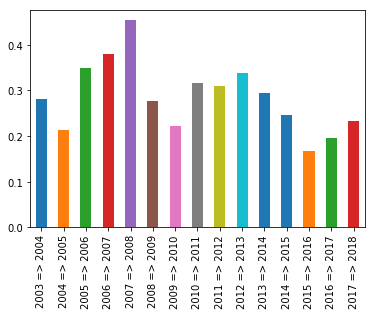

In [83]:
predict_from_rinj = predict_day_all(f_cdj, feature=f_rinj)
print(predict_from_rinj.mean())

0.27380791885799455


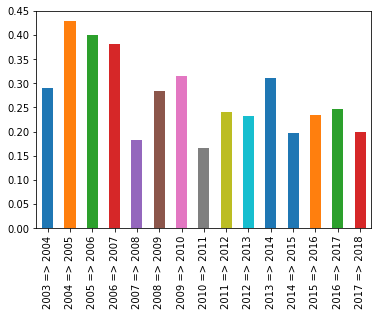

In [75]:
predict_from_rinj = predict_day_all(f_cdj, feature=f_rinj, cumsum=True)
print(predict_from_rinj.mean())

### ROCK IN JAPAN from COUNT DOWN JAPAN

0.27584180836566935


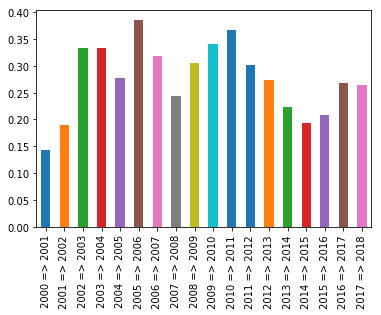

In [76]:
predict_from_cdj = predict_day_all(f_rinj, feature=f_cdj)
print(predict_from_cdj.mean())

0.2616732993813693


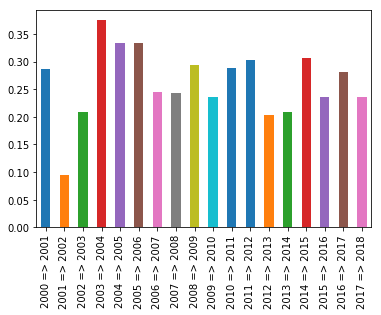

In [77]:
predict_from_cdj = predict_day_all(f_rinj, feature=f_cdj, cumsum=True)
print(predict_from_cdj.mean())

## Next Year

In [78]:
def make_predict_model(df, from_year, cumsum=False, feature=None, test_size=0.33,):
    years = df["year"].value_counts().index.values.astype(int)
    years.sort()
    years = years[:(years.tolist().index(from_year))]
    f_columns =  [c for c in df.columns if c.startswith("day_category")]
    feature = feature
    if feature is None:
        feature = df
    
    Xs = []
    ys = []
    
    def make_feature(year):
        if cumsum:
            X = feature[feature["year"] <= year][["artist"] + f_columns].groupby(["artist"])[f_columns].sum().reset_index()
        else:
            X = feature[feature["year"] == year][["artist"] + f_columns]
        return X
    
    for y in years[1:]:
        X = make_feature(y - 1)
        y = df[df["year"] == y][["artist", "day_index"]]
        Xy = y.merge(X, left_on="artist", right_on="artist", how="left").fillna(0)
        X = Xy[f_columns]
        y = Xy["day_index"]
        
        Xs.append(X)
        ys.append(y)
    
    X = pd.concat(Xs, axis=0)
    y = pd.concat(ys, axis=0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    model = LogisticRegression(solver="liblinear", multi_class="ovr", class_weight="balanced").fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    nX = make_feature(from_year)
    prediction = model.predict_proba(nX[f_columns])
    prediction = pd.DataFrame(prediction, index=nX["artist"])
    return score, prediction

In [105]:
score, prediction_cdj = make_predict_model(f_cdj, 2017, cumsum=True)
prediction_cdj[prediction_cdj.max(axis=1) >= 0.6].style.highlight_max(axis=1)

,0,1,2,3
artist,,,,
AA=,0.0401223,0.166327,0.146067,0.647484
B-DASH,0.0240965,0.0823124,0.100891,0.7927
Base Ball Bear,0.00744248,0.11741,0.119594,0.755554
DOES,0.0607367,0.145428,0.15884,0.634996
Nothing's Carved In Stone,0.0360346,0.148311,0.19088,0.624774
POLYSICS,0.0165097,0.0719374,0.0907581,0.820795
People In The Box,0.0675083,0.143165,0.143044,0.646283
RHYMESTER,0.0316786,0.191001,0.149023,0.628297
SPECIAL OTHERS,0.0213929,0.095612,0.0932918,0.789703


In [110]:
score, prediction_rinj = make_predict_model(f_rinj, 2018, cumsum=True)
print(score)

0.3062015503875969


In [111]:
prediction_rinj[prediction_rinj.max(axis=1) >= 0.6].style.highlight_max(axis=1)

,0,1,2,3
artist,,,,
9mm Parabellum Bullet,0.185289,0.0880745,0.0952623,0.631374
DJ和,0.114603,0.0368935,0.041614,0.80689
ROTTENGRAFFTY,0.183835,0.0801345,0.120899,0.615132
dustbox,0.191882,0.0665551,0.133547,0.608016
パスピエ,0.164089,0.110186,0.0985543,0.627171
中村一義,0.165709,0.108868,0.101384,0.624039
忘れらんねえよ,0.17372,0.0970027,0.105853,0.623424


In [113]:
score, prediction_rinj_from_cdj = make_predict_model(f_rinj, 2018, cumsum=True, feature=f_cdj)
prediction_rinj_from_cdj[prediction_rinj_from_cdj.max(axis=1) >= 0.6].style.highlight_max(axis=1)

,0,1,2,3
artist,,,,
POLYSICS,0.120572,0.0924907,0.128702,0.658235
THE BACK HORN,0.159994,0.122299,0.112507,0.6052
plenty,0.176436,0.115076,0.106375,0.602113
the HIATUS,0.164307,0.120387,0.113541,0.601765
サンボマスター,0.152587,0.125768,0.120982,0.600663
